In [2]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from quilt.data.ResidentMario import geoplot_data
import geoplot as gplt
import geoplot.crs as gcrs
import geopandas as gpd
from shapely.geometry import Point

In [3]:
# Import dataset
fatalities_df = pd.read_csv('raw_data/Police Fatalities.csv', encoding = "ISO-8859-1")

In [4]:
# Look at the top few rows of the data frame
fatalities_df.head()

,UID,Name,Age,Gender,Race,Date,City,State,Manner_of_death,Armed,Mental_illness,Flee
0,133,Karen O. Chin,44.0,Female,Asian,5/4/2000,Alameda,CA,Shot,NaN,False,False
1,169,Chyraphone Komvongsa,26.0,Male,Asian,6/2/2000,Fresno,CA,Shot,NaN,False,False
2,257,Ming Chinh Ly,36.0,Male,Asian,8/13/2000,Rosemead,CA,Shot,Gun,False,False
3,483,Kinh Quoc Dao,29.0,Male,Asian,2/9/2001,Valley Glen,CA,Shot,Gun,False,False
4,655,Vanpaseuth Phaisouphanh,25.0,Male,Asian,6/10/2001,Riverside,CA,Shot,Knife,False,False


In [5]:
# Create a new column for year so that we can aggregate by year
years = []

for dt in fatalities_df["Date"]:
    conv_dt = datetime.strptime(dt, '%m/%d/%Y')
    
    years.append(conv_dt.year)
    
fatalities_df["Year"] = years

In [6]:
fatalities_df.head()

,UID,Name,Age,Gender,Race,Date,City,State,Manner_of_death,Armed,Mental_illness,Flee,Year
0,133,Karen O. Chin,44.0,Female,Asian,5/4/2000,Alameda,CA,Shot,NaN,False,False,2000
1,169,Chyraphone Komvongsa,26.0,Male,Asian,6/2/2000,Fresno,CA,Shot,NaN,False,False,2000
2,257,Ming Chinh Ly,36.0,Male,Asian,8/13/2000,Rosemead,CA,Shot,Gun,False,False,2000
3,483,Kinh Quoc Dao,29.0,Male,Asian,2/9/2001,Valley Glen,CA,Shot,Gun,False,False,2001
4,655,Vanpaseuth Phaisouphanh,25.0,Male,Asian,6/10/2001,Riverside,CA,Shot,Knife,False,False,2001


In [8]:
# Identify what the armed data consists of
fatalities_df["Armed"].value_counts()

Gun                                 4703
Knife                               1361
Unarmed                              400
Vehicle                              111
Toy Weapon                            69
Toy weapon                            29
Machete                               16
Unknown Weapon                        15
Sword                                  8
Hammer                                 7
Box Cutter                             7
Baseball Bat                           6
Tasered                                6
Axe                                    6
Metal Pipe                             5
Hatchet                                5
Crossbow                               3
Screwdriver                            3
Gun And Knife                          3
Guns And Explosives                    3
Metal Stick                            2
Blunt Object                           2
Meat Cleaver                           2
Metal Pole                             2
Shovel          

In [27]:
# Defining what unarmed means is tricky, this is my best approximation
grouped_df = fatalities_df.loc[(fatalities_df["Armed"] == "Unarmed") |\
                               (fatalities_df["Armed"] == "Toy Weapon") | \
                               (fatalities_df["Armed"] == "Toy weapon") \
                               , :].groupby("Year")

unarmed_shootings_by_year = grouped_df["Name"].count().reset_index()

# Save this dataset to a csv for plotting
unarmed_shootings_by_year.to_csv('raw_data/unarmed_shootings_clean.csv')

In [28]:
# Define armed inversely
grouped_df = fatalities_df.loc[(fatalities_df["Armed"] != "Unarmed") &\
                               (fatalities_df["Armed"] != "Toy Weapon") & \
                               (fatalities_df["Armed"] != "Toy weapon") \
                               , :].groupby("Year")

armed_shootings_by_year = grouped_df["Name"].count().reset_index()

# Save this dataset to a csv for plotting
armed_shootings_by_year.to_csv('raw_data/armed_shootings_clean.csv')

In [29]:
# Group the total fatalities by state to analyze by location
grouped_df = fatalities_df.groupby("State")

shootings_by_state = grouped_df["Name"].count().reset_index()

shootings_by_state.head()

,State,Name
0,AK,73
1,AL,326
2,AR,70
3,AZ,585
4,CA,2913


In [30]:
# Dictionary of state abbreviations and state names
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [31]:
# Import the lat/long data for each state
state_locs = pd.read_csv('raw_data/state_lat_long.csv', usecols=['state name', 'latitude', 'longitude'])
state_locs.head()
geodata = pd.read_csv('raw_data/state_lat_long.csv', usecols=['state name', 'latitude', 'longitude'])

,state name,latitude,longitude
0,Alabama,32.7794,-86.8287
1,Alaska,64.0685,-52.2782
2,Arizona,34.2744,-11.6602
3,Arkansas,34.8938,-92.4426
4,California,37.1841,-19.4696


In [32]:
# Loop through each state, joining from abbreviation to name and adding them to a new data frame
tracking_list = []

for index, row in shootings_by_state.iterrows():
    state = states[row['State']]
    tracking_list.append(state)
    
shootings_by_state['state name'] = tracking_list

shootings_by_state.head()

,State,Name,state name
0,AK,73,Alaska
1,AL,326,Alabama
2,AR,70,Arkansas
3,AZ,585,Arizona
4,CA,2913,California


In [39]:
# Join over state name so we are left with the names, fatalities and the lat/lng
merged_df = pd.merge(shootings_by_state, state_locs, on="state name")

merged_df = merged_df.rename(columns={"Name": "Fatalities"})

merged_df = merged_df[["state name", "Fatalities", "latitude", "longitude"]]

merged_df.head()

,state name,Fatalities,latitude,longitude
0,Alaska,73,64.0685,-52.2782
1,Alabama,326,32.7794,-86.8287
2,Arkansas,70,34.8938,-92.4426
3,Arizona,585,34.2744,-11.6602
4,California,2913,37.1841,-19.4696


In [40]:
# This data is ready to be plotted so save it to a CSV
merged_df.to_csv('raw_data/lat_long_states_fatalities.csv')

In [22]:
# Read in the yearly census data
census_df = pd.read_csv('raw_data/census_cleaned.csv', usecols=['State', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])

census_df.head()

,State,2010,2011,2012,2013,2014,2015,2016,2017
0,Alabama,4785579.0,4798649.0,4813946.0,4827660.0,4840037.0,4850858.0,4860545.0,4874747.0
1,Alaska,714015.0,722259.0,730825.0,736760.0,736759.0,737979.0,741522.0,739795.0
2,Arizona,6407002.0,6465488.0,6544211.0,6616124.0,6706435.0,6802262.0,6908642.0,7016270.0
3,Arkansas,2921737.0,2938640.0,2949208.0,2956780.0,2964800.0,2975626.0,2988231.0,3004279.0
4,California,37327690.0,37672654.0,38019006.0,38347383.0,38701278.0,39032444.0,39296476.0,39536653.0


In [23]:
# Compute the mean population between 2010 to 2017 to approximate the population by state
mean_pop = []

for index, row in census_df.iterrows():
    state = row["State"]
    
    avg_pop = row[['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']].mean()
    
    mean_pop.append(avg_pop)
    
census_df["Mean Population"] = mean_pop

census_df = census_df.rename(columns={"State":"state name"})

census_df.head()

,state name,2010,2011,2012,2013,2014,2015,2016,2017,Mean Population
0,Alabama,4785579.0,4798649.0,4813946.0,4827660.0,4840037.0,4850858.0,4860545.0,4874747.0,4.831503e+06
1,Alaska,714015.0,722259.0,730825.0,736760.0,736759.0,737979.0,741522.0,739795.0,7.324892e+05
2,Arizona,6407002.0,6465488.0,6544211.0,6616124.0,6706435.0,6802262.0,6908642.0,7016270.0,6.683304e+06
3,Arkansas,2921737.0,2938640.0,2949208.0,2956780.0,2964800.0,2975626.0,2988231.0,3004279.0,2.962413e+06
4,California,37327690.0,37672654.0,38019006.0,38347383.0,38701278.0,39032444.0,39296476.0,39536653.0,3.849170e+07


In [41]:
# Write this data to a CSV for plotting
census_df.to_csv("raw_data/mean_populations_by_state.csv")

In [24]:
merged_df = pd.merge(gdf, census_df, on="state name")[["state name", "Fatalities", "Mean Population", "geometry"]]

merged_df["Fatalities adjusted by Population"] = 100000*merged_df["Fatalities"]/merged_df["Mean Population"]

merged_df.head()

,state name,Fatalities,Mean Population,geometry,Fatalities adjusted by Population
0,Alabama,326,4.831503e+06,POINT (-86.8287 32.7794),6.747383
1,Arkansas,70,2.962413e+06,POINT (-92.4426 34.8938),2.362939
2,Arizona,585,6.683304e+06,POINT (-11.6602 34.2744),8.753155
3,California,2913,3.849170e+07,POINT (-19.4696 37.1841),7.567866
4,Colorado,310,5.316668e+06,POINT (-5.5478 38.9972),5.830720


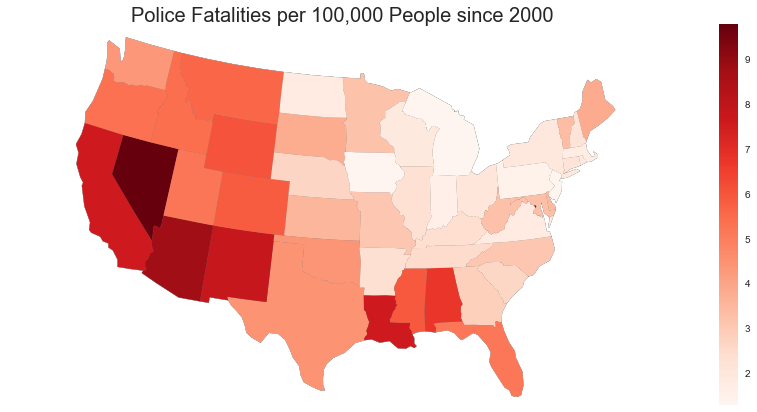

In [26]:
continental_usa = gpd.read_file(geoplot_data.contiguous_usa())
continental_usa = continental_usa.set_index("State")

ax = gplt.polyplot(continental_usa, projection=gcrs.AlbersEqualArea(), figsize = (15,7))

gplt.aggplot(merged_df, projection=gcrs.AlbersEqualArea(), hue='Fatalities adjusted by Population', cmap='Reds',
             by='state name', geometry=continental_usa.geometry, ax=ax, linewidth=0)

plt.title("Police Fatalities per 100,000 People since 2000", size = 20)

plt.show()